## Import Modules

In [1]:
import re, sys, os
import logging
from pathlib import Path
from datetime import datetime
import numpy as np
import torch
import torch_directml
from fastai.vision.all import *
from fastai.vision.augment import _init_mat


torch._logging.set_logs(all=logging.INFO)

In [ ]:
print("="*80)
print("DIRECTML FULL DEBUG LOG STARTED")
print(f"torch version: {torch_directml.torch.__version__}")
print(f"Device: {torch_directml.device()}")
print(f"GPU: {torch_directml.device_name(0)}")
print("="*80)

DIRECTML FULL DEBUG LOG STARTED
torch version: 2.4.1+cpu
Device: privateuseone:0
GPU: Radeon RX 560X 


In [3]:
# 1. Detect DirectML device (no global default!)
dml = torch_directml.device()
print("="*80)

# # 3. Global monkey-patch for Normalize (fixes later device mismatch in transforms)
old_init = Normalize.__init__
def new_init(self, mean, std, axes=(0,2,3)):
    old_init(self, mean.to(dml), std.to(dml), axes=axes)
Normalize.__init__ = new_init

In [ ]:
from fastai.learner import Learner

def directml_safe_freeze_to(self: Learner, n: int):
    backbone = self.model[0]
    backbone_ids = {id(p) for p in backbone.parameters()}
    
    # ONLY set requires_grad (DirectML-safe)
    if n == 0:
        for p in self.model.parameters():
            p.requires_grad_(True)
    else:
        for p in backbone.parameters():
            p.requires_grad_(False)
        for p in self.model.parameters():
            if id(p) not in backbone_ids:
                p.requires_grad_(True)

    # Clear state if opt exists (harmless)
    if self.opt is not None:
        self.opt.clear_state()
    
    print(f"DirectML-safe freeze_to({n}) — requires_grad set")

Learner.freeze_to = directml_safe_freeze_to

## Set device to Torch-DirectML detected device

## Load Data to train on

In [5]:
# 4. Load data (splitting now uses CPU randperm, no crash)
path = untar_data(URLs.CAMVID_TINY)
files = get_image_files(path / "images")
codes = np.loadtxt(path / 'codes.txt', dtype=str)

## Create Fastai DataLoaders

In [ ]:
def label_func(x): return path/'labels'/f'{x.stem}_P{x.suffix}'

dls = SegmentationDataLoaders.from_label_func(
    path,
    bs=8,  # Adjust based on your GPU VRAM (e.g., 32 for lower-end)
    fnames=files,
    label_func=label_func,
    codes=codes,
    device=dml,  # Pin batches to DirectML
    num_workers=0  # Avoid multiprocessing issues with DirectML
)

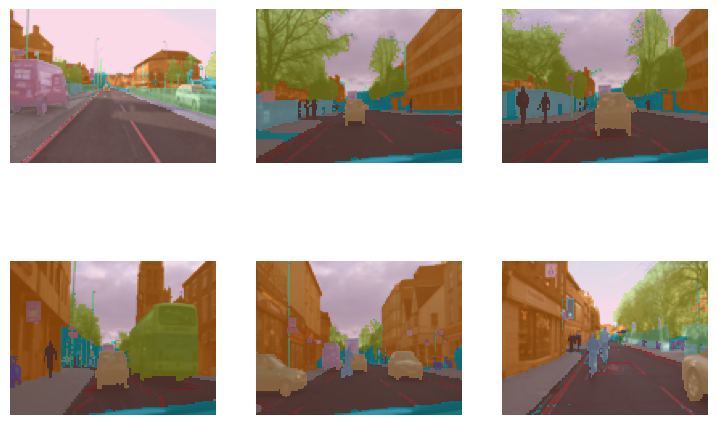

In [7]:
# Show one batch to verify labels are correct
dls.show_batch(max_n=6)

In [8]:
test_file = files[0]
print("="*80)
label = (
    f"File: {test_file.name}, "
    f"Label: {f'{test_file.stem}_P{test_file.suffix}'}"
)
print(label)

File: 0001TP_006750.png, Label: 0001TP_006750_P.png


## Create Learner
### Transfer model and everything to Torch-DirectML detected device

In [9]:
# 5. Create learner on CPU first, then move to DML
learn = unet_learner(dls, resnet34, metrics=[DiceMulti()]) # resnet18, 34, 50, 101, 152
learn = learn.to_fp16(enabled=False)   # ← disables mixed precision completely
learn.to(dml)  # Explicitly move to DirectML
""

DirectML-safe freeze_to(-1) — requires_grad set


''

## Start the training/fine-tuning

In [10]:
print("="*80)
learn.fine_tune(epochs=25)
print("="*80)

DirectML-safe freeze_to(-1) — requires_grad set


f:\Projects\VsCodium\Python\2025\GenAI\11\.venv3_12_9\Lib\site-packages\torch\amp\autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
f:\Projects\VsCodium\Python\2025\GenAI\11\.venv3_12_9\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,dice_multi,time
0,3.122067,2.429433,0.055894,00:11


DirectML-safe freeze_to(0) — requires_grad set


epoch,train_loss,valid_loss,dice_multi,time
0,2.171668,1.805511,0.079059,00:14
1,1.863638,1.319752,0.099002,00:14
2,1.611222,1.156256,0.111482,00:14
3,1.434880,1.052173,0.156201,00:14
4,1.309463,0.960521,0.174808,00:14
5,1.188782,0.843080,0.196259,00:15
6,1.080311,0.773015,0.221447,00:14
7,0.989689,0.885164,0.216541,00:15
8,0.915597,0.725980,0.239717,00:15
9,0.845145,0.734433,0.245720,00:15


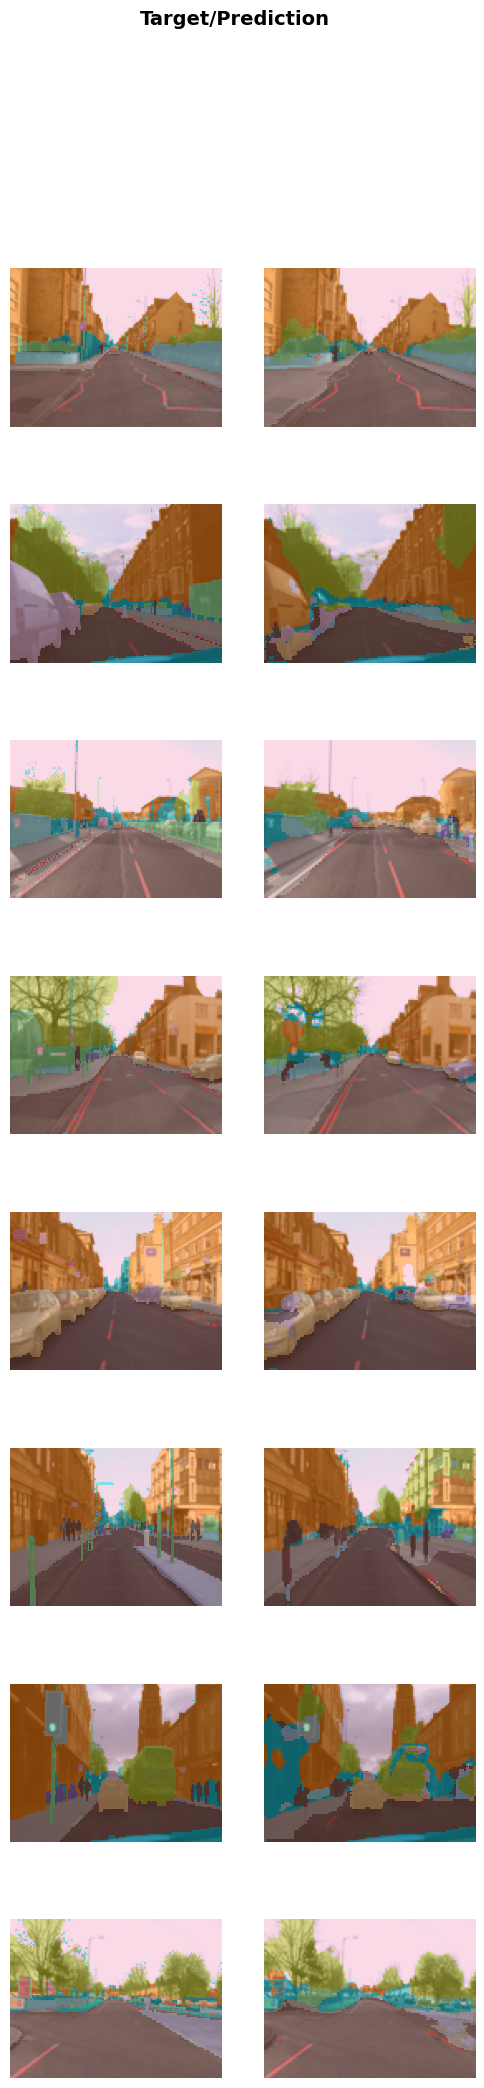

In [11]:
learn.show_results()

In [12]:
# interpreter = ClassificationInterpretation.from_learner(learn)

In [13]:
# interpreter.plot_confusion_matrix()

In [14]:
# interpreter.plot_top_losses(k=10)